# Targeting

## Fake data

In [16]:
import pandas as pd
import numpy as np
from faker import Faker

def create_customer_data(num_customers=1000):
    fake = Faker()
    np.random.seed(42)
    
    # Define means and covariance matrix for the log-transformed variables (volume and expected_clv)
    log_means = np.log([500, 5000])  # Mean values for the log-transformed volume and expected_clv
    log_cov_matrix = [
        [0.2, -0.5],
        [-0.5, 0.3]
    ]  # Covariance matrix for the log-transformed volume and expected_clv with specified correlation
    
    # Generate correlated log-transformed data for volume and expected_clv
    log_correlated_data = np.random.multivariate_normal(log_means, log_cov_matrix, size=num_customers)
    
    # Exponentiate to get the original scale
    correlated_data = np.exp(log_correlated_data)
    
    # Define means and covariance matrix for growth_rate and roi
    means_growth_roi = [0.15, 0.2]
    cov_growth_roi = [
        [0.01, -0.005],
        [-0.005, 0.01]
    ]  # Covariance matrix for growth_rate and roi with specified correlation
    
    # Generate correlated data for growth_rate and roi
    correlated_growth_roi = np.random.multivariate_normal(means_growth_roi, cov_growth_roi, size=num_customers)
    
    # Apply transformation to keep growth_rate and roi within specified bounds
    growth_rate = np.clip(correlated_growth_roi[:, 0], 0.01, 0.3)
    roi = np.clip(correlated_growth_roi[:, 1], -1, 1)
    
    customer_data = []
    
    for i in range(num_customers):
        customer_id = fake.uuid4()
        volume = max(1, round(correlated_data[i, 0]))  # Ensure volume is at least 1
        expected_clv = round(max(100, correlated_data[i, 1]), 2)  # Ensure expected_clv is at least 100
        growth_rate_val = round(growth_rate[i], 2)  # Ensure growth_rate is within specified bounds
        roi_val = round(roi[i], 2)  # Ensure roi is within specified bounds
        cac = round(np.random.uniform(50, 5000), 2)
        dim_1 = fake.random_int(min=1, max=5)
        dim_2 = fake.random_element(elements=('A', 'B', 'C', 'D', 'E'))
        dim_3 = fake.random_number(digits=2)
        
        customer_data.append([
            customer_id,
            volume,
            growth_rate_val,
            expected_clv,
            cac,
            roi_val,
            dim_1,
            dim_2,
            dim_3
        ])
    
    columns = ['customer_id', 'volume', 'growth_rate', 'expected_clv', 'cac', 'roi', 'dim_1', 'dim_2', 'dim_3']
    return pd.DataFrame(customer_data, columns=columns)

# Generate the data
data = create_customer_data()
data

/var/folders/65/1b1td3_n3f977_x9vc2b967w0000gn/T/ipykernel_84061/3328179605.py:17: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  log_correlated_data = np.random.multivariate_normal(log_means, log_cov_matrix, size=num_customers)


,customer_id,volume,growth_rate,expected_clv,cac,roi,dim_1,dim_2,dim_3
0,a6937165-0591-477b-9a75-0e1f9c02b70e,394,0.20,7210.48,2450.84,0.13,3,B,9
1,aef7a7ab-f26f-4711-9c0d-5242d91eaabc,194,0.20,4538.05,472.74,0.12,4,B,68
2,48a87976-ec64-40c5-a96f-76b709ced853,625,0.30,4654.24,4863.68,0.05,3,A,53
3,92617bcd-a60a-47fa-b0f2-0f0964d3c63c,150,0.11,10658.99,2614.15,0.16,4,C,92
4,f8c0ae95-7a8e-4b4c-b35f-ec387a13892e,537,0.14,3078.81,3090.22,0.30,1,C,39
...,...,...,...,...,...,...,...,...,...
995,4d4facc1-b94e-49ec-acd7-4f99a6ef2fa0,237,0.27,6487.79,1703.53,0.03,2,E,55
996,a9629c76-03b0-493b-8e1d-f5d717156535,192,0.30,8459.64,578.76,0.07,2,A,34
997,2593a50a-f5e0-42d7-860c-f0800cd6233a,274,0.30,4369.55,1232.28,0.02,3,D,84
998,fcadcf5e-0824-4543-9388-42691a86c1f8,705,0.30,6617.54,4748.94,0.00,2,C,0


## Multi-objective targeting: Volume vs value

/var/folders/65/1b1td3_n3f977_x9vc2b967w0000gn/T/ipykernel_84061/3328179605.py:17: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  log_correlated_data = np.random.multivariate_normal(log_means, log_cov_matrix, size=num_customers)
/var/folders/65/1b1td3_n3f977_x9vc2b967w0000gn/T/ipykernel_84061/1483538132.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(data[dim]) or data[dim].dtype == object:


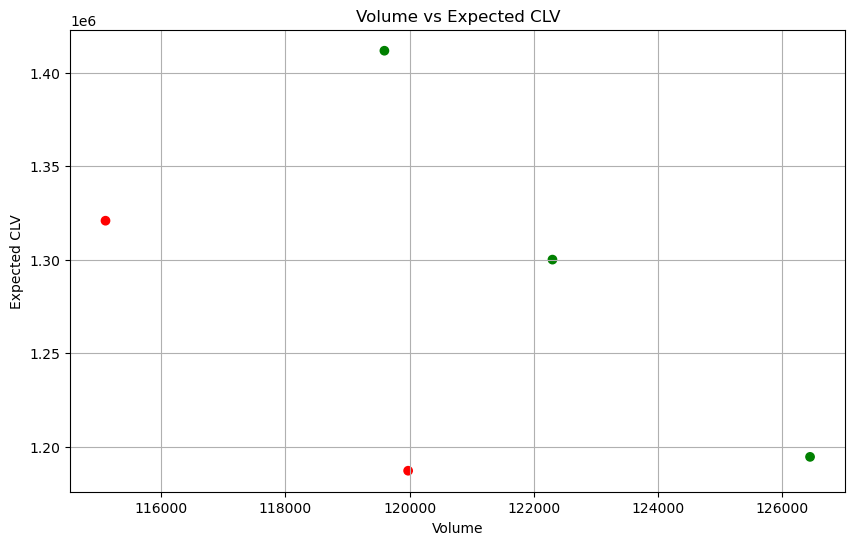

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def targeting_vv(data, volume_col='volume', clv_col='expected_clv', dim=None):
    def is_dominated(row, df):
        return any(
            (df[volume_col] > row[volume_col]) & (df[clv_col] > row[clv_col])
        )
    
    if dim:
        if pd.api.types.is_categorical_dtype(data[dim]) or data[dim].dtype == object:
            # Aggregate by categorical dimension
            aggregated_data = data.groupby(dim).agg({volume_col: 'sum', clv_col: 'sum'}).reset_index()
        else:
            # Aggregate by quartiles if dimension is continuous
            data['quartile'] = pd.qcut(data[dim], 4, labels=False)
            aggregated_data = data.groupby('quartile').agg({volume_col: 'sum', clv_col: 'sum'}).reset_index()
    else:
        aggregated_data = data
    
    # Determine dominated and non-dominated strategies
    aggregated_data['dominated'] = aggregated_data.apply(is_dominated, axis=1, df=aggregated_data)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(aggregated_data[volume_col], aggregated_data[clv_col], c=aggregated_data['dominated'].map({True: 'red', False: 'green'}))
    plt.title('Volume vs Expected CLV')
    plt.xlabel('Volume')
    plt.ylabel('Expected CLV')
    plt.grid(True)
    plt.show()

# Example usage
# Assuming 'data' is a DataFrame containing the relevant columns
data = create_customer_data()
targeting_vv(data, volume_col='volume', clv_col='expected_clv', dim='dim_2')

## Multi-objective targeting: Growth vs ROI

/var/folders/65/1b1td3_n3f977_x9vc2b967w0000gn/T/ipykernel_84061/3328179605.py:17: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  log_correlated_data = np.random.multivariate_normal(log_means, log_cov_matrix, size=num_customers)


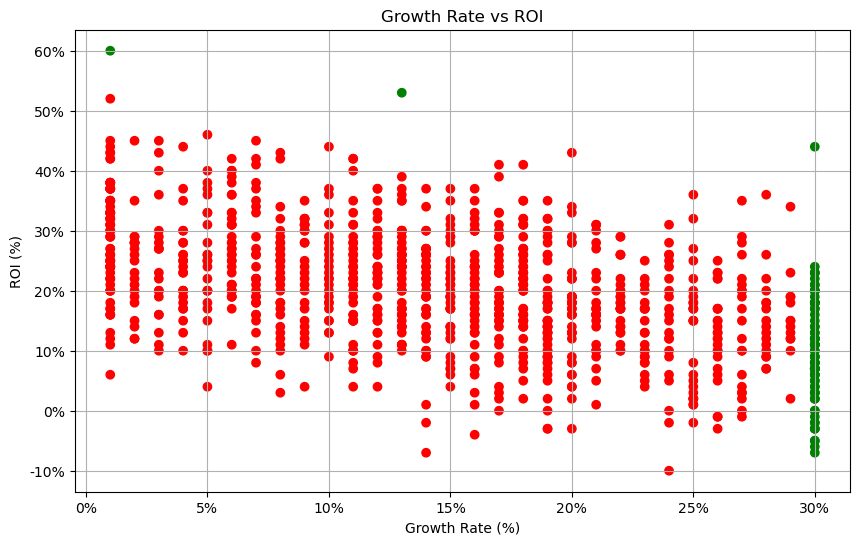

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def targeting_gr(data, gr_col='growth_rate', roi_col='roi', dim=None):
    def is_dominated(row, df):
        return any(
            (df[gr_col] > row[gr_col]) & (df[roi_col] > row[roi_col])
        )
    
    if dim:
        if pd.api.types.is_categorical_dtype(data[dim]) or data[dim].dtype == object:
            # Aggregate by categorical dimension
            aggregated_data = data.groupby(dim).agg({gr_col: 'mean', roi_col: 'mean'}).reset_index()
        else:
            # Aggregate by quartiles if dimension is continuous
            data['quartile'] = pd.qcut(data[dim], 4, labels=False)
            aggregated_data = data.groupby('quartile').agg({gr_col: 'mean', roi_col: 'mean'}).reset_index()
    else:
        aggregated_data = data
    
    # Determine dominated and non-dominated strategies
    aggregated_data['dominated'] = aggregated_data.apply(is_dominated, axis=1, df=aggregated_data)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(aggregated_data[gr_col], aggregated_data[roi_col], c=aggregated_data['dominated'].map({True: 'red', False: 'green'}))
    plt.title('Growth Rate vs ROI')
    plt.xlabel('Growth Rate (%)')
    plt.ylabel('ROI (%)')
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.show()

# Example usage
# Assuming 'data' is a DataFrame containing the relevant columns
data = create_customer_data()
targeting_gr(data, gr_col='growth_rate', roi_col='roi', dim=None)